In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


In [2]:
!ls

'Background materials for interview.pdf'   requirements.txt
 chemical_reaction_model.ipynb		   TestDatabase.xlsx


In [3]:
df = pd.read_excel("TestDatabase.xlsx")
print(df.shape)
df.head()

(28814, 13)


,conti_Ca,conti_Cb,conti_Ca_in,conti_Tsp,conti_m_in,conti_mfree_A_liq,conti_mfree_B_liq,conti_mfree_A_gas,conti_mfree_B_gas,conti_Pinert,conti_P_A,conti_P_B,conti_Ptot
0,12.500000,0.000000,13.062965,357.047056,2.0,35000.000000,0.000000,3500.000000,0.000000,100000.0,8.658575e+06,0.000000,8.758575e+06
1,12.393228,0.107255,13.062965,357.047056,2.0,34701.037604,225.234700,3470.103760,22.523470,100000.0,8.584615e+06,74293.771118,8.758909e+06
2,12.287463,0.213502,13.062965,357.047056,2.0,34404.895408,448.353382,3440.489541,44.835338,100000.0,8.511353e+06,147889.572820,8.759243e+06
3,12.182695,0.318750,13.062965,NaN,2.0,34111.546805,669.376002,3411.154681,66.937600,100000.0,8.438782e+06,220793.987390,8.759576e+06
4,12.078916,0.423011,13.062965,NaN,2.0,33820.965450,888.322320,3382.096545,88.832232,100000.0,8.366896e+06,293013.532865,8.759909e+06


# **GOAL**: For the operator in charge of the process, it is important to understand how the concentrations of the products (conti_Ca & conti_Cb) in the outgoing flows evolve as a function of all other parameters. 
# model **conti_Ca_in** with the remaining parameters and predict **conti_Cb** and **conti_Ca** with a regression mode in two separate models

In [4]:
# Assuming your DataFrame is named 'df'
# Replace 'your_column_names' with the actual names of your columns

def custom_describe(df):
    summary_stats = pd.DataFrame(index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing'])

    for column in df.columns:
        column_stats = []

        # Count (including missing values)
        count_with_missing = len(df[column])
        column_stats.append(count_with_missing)

        # Mean
        mean = df[column].mean()
        column_stats.append(mean)

        # Standard Deviation
        std = df[column].std()
        column_stats.append(std)

        # Min
        min_value = df[column].min()
        column_stats.append(min_value)

        # Percentiles
        percentiles = df[column].describe(percentiles=[.25, .5, .75])
        column_stats.extend(percentiles.loc[['25%', '50%', '75%']])

        # Max
        max_value = df[column].max()
        column_stats.append(max_value)

        # Missing values
        missing_values = df[column].isnull().sum()
        column_stats.append(missing_values)

        summary_stats[column] = column_stats

    return summary_stats

# Use the custom_describe function
result = custom_describe(df)

# Display the result
result

,conti_Ca,conti_Cb,conti_Ca_in,conti_Tsp,conti_m_in,conti_mfree_A_liq,conti_mfree_B_liq,conti_mfree_A_gas,conti_mfree_B_gas,conti_Pinert,conti_P_A,conti_P_B,conti_Ptot
count,28814.000000,28814.000000,28814.000000,28814.000000,28814.000000,28814.000000,28814.000000,28814.000000,28814.000000,28814.000000,2.881400e+04,2.881400e+04,2.881400e+04
mean,1.922393,10.406138,12.316871,342.111382,1.998974,5360.959562,21893.577793,535.748079,2182.266352,95822.416647,1.178100e+06,6.990810e+06,8.281141e+06
std,1.787991,1.890978,1.465869,39.715066,0.045287,4945.897532,3930.220657,499.628285,398.065655,11108.186700,1.062159e+06,1.840688e+06,1.037761e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,6.137713e+06
25%,0.383703,9.325844,11.022312,310.289243,2.000000,1082.743302,19681.953990,99.455091,1954.156648,86904.299628,2.610664e+05,5.614513e+06,7.408385e+06
50%,1.432586,10.809126,12.263535,343.752171,2.000000,4027.579484,22693.026412,400.794092,2268.253785,97431.355818,9.124696e+05,6.983922e+06,8.341341e+06
75%,2.953676,11.746921,13.485383,379.700172,2.000000,8270.495996,24693.040264,829.688187,2467.542197,106344.574410,1.794184e+06,8.473851e+06,8.986956e+06
max,12.500000,13.687907,14.922942,407.278453,2.000000,35000.000000,28744.604631,3500.000000,2874.460463,114068.565048,8.658575e+06,1.066725e+07,1.086888e+07
missing,1056.000000,1916.000000,1975.000000,1820.000000,1522.000000,2059.000000,2217.000000,1704.000000,1355.000000,1544.000000,1.360000e+03,1.710000e+03,1.309000e+03


# Correlation matrix 

In [5]:
def pearson_correlation(X):
    data = X
    corr_pearson = data.corr(method='pearson')
    plt.subplots(figsize=(15,10))
    sns.heatmap(corr_pearson)
    # drop correlated feature
    # Return a new array of given shape and type, filled with fill_value.
    columns = np.full((corr_pearson.shape[0],), True, dtype=bool) 
    for i in range(corr_pearson.shape[0]):
        for j in range(i+1, corr_pearson.shape[0]):
            if corr_pearson.iloc[i,j] >= 0.75:
                if columns[j]:
                    columns[j] = False
    selected_columns_pearson = data.columns[columns]
    return selected_columns_pearson, corr_pearson

def spearman_correlation(X):
    data = X
    corr_spearman = data.corr(method='spearman')
    plt.subplots(figsize=(15,10))
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    # Returns a new array of given shape and type, filled with fill_value.
    columns = np.full((corr_spearman.shape[0],), True, dtype=bool) 
    for i in range(corr_spearman.shape[0]):
        for j in range(i+1, corr_spearman.shape[0]):
            if corr_spearman.iloc[i,j] >= 0.75:
                if columns[j]:
                    columns[j] = False
    selected_columns_spearman = data.columns[columns]
    return selected_columns_spearman, corr_spearman

(Index(['conti_Ca', 'conti_Cb', 'conti_Ca_in', 'conti_Tsp', 'conti_m_in'], dtype='object'),
                    conti_Ca  conti_Cb  conti_Ca_in  conti_Tsp  conti_m_in  \
 conti_Ca           1.000000 -0.921903    -0.009878  -0.735159    0.039949   
 conti_Cb          -0.921903  1.000000     0.133701   0.669106    0.040657   
 conti_Ca_in       -0.009878  0.133701     1.000000   0.088124    0.040677   
 conti_Tsp         -0.735159  0.669106     0.088124   1.000000    0.040569   
 conti_m_in         0.039949  0.040657     0.040677   0.040569    1.000000   
 conti_mfree_A_liq  1.000000 -0.921478     0.004202  -0.728513    0.040703   
 conti_mfree_B_liq -0.922602  1.000000     0.100239   0.675818    0.040826   
 conti_mfree_A_gas  1.000000 -0.923177     0.004850  -0.736597    0.040365   
 conti_mfree_B_gas -0.922787  1.000000     0.119795   0.659986    0.040203   
 conti_Pinert      -0.738270  0.665400     0.072496   1.000000    0.040328   
 conti_P_A          0.996673 -0.915857     0.01359

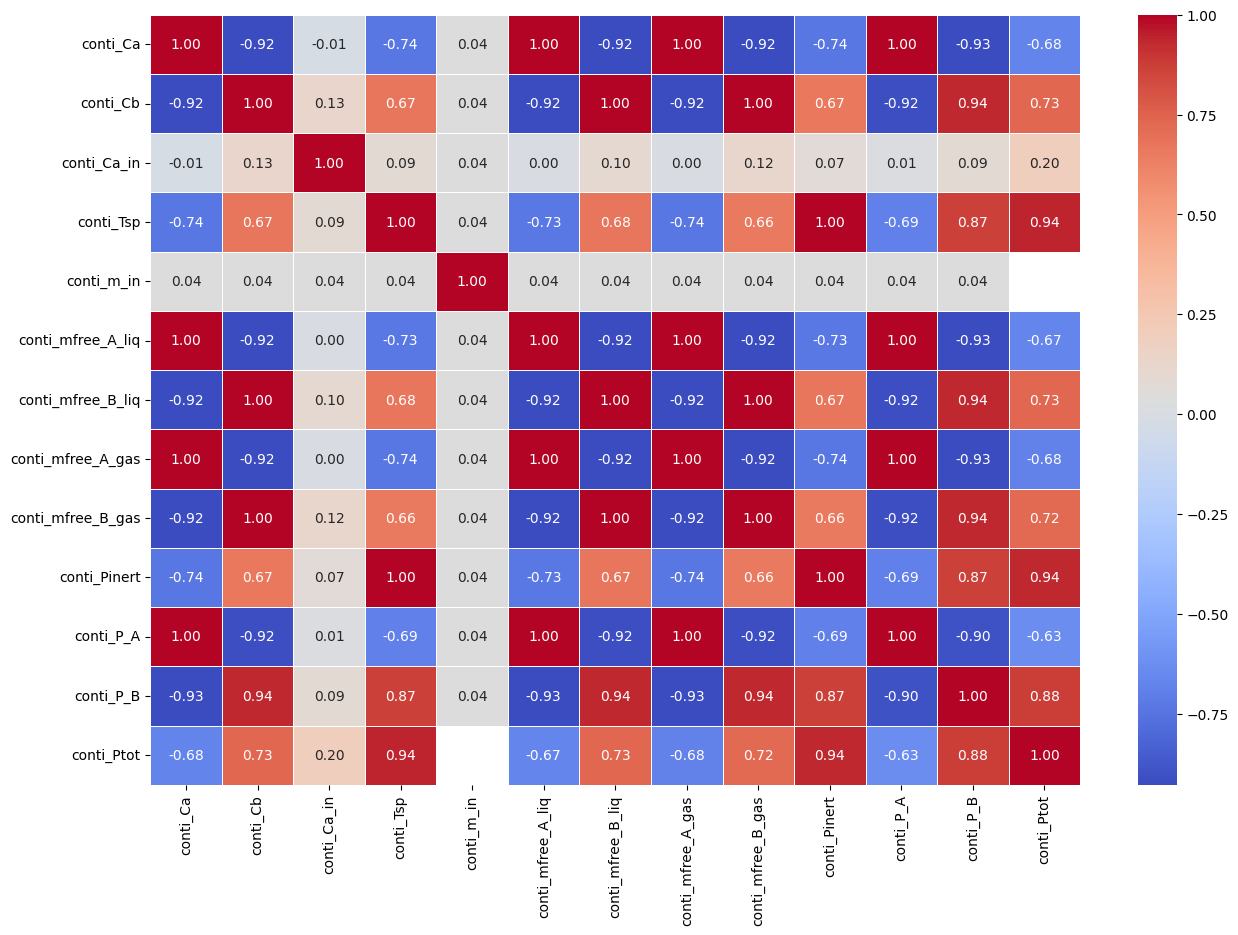

In [6]:
spearman_correlation(df)

# Small vs large gaps treatment

In [7]:
# Create a timestamp column based on the assumption that rows are 15 seconds apart
df['timestamp'] = pd.date_range(start='2024-01-01', periods=len(df), freq='15S')
df['timestamp_diff'] = df['timestamp'].diff()

# Set the threshold for large gaps
large_gap_threshold = pd.Timedelta(minutes=9)

# Identify gaps equal or larger than 9 minutes for each column
large_gaps_columns = {}
for column in df.columns:
    large_gaps_columns[column] = df[df[column].isnull() & (df['timestamp_diff'] >= large_gap_threshold)]

# Drop the temporary 'timestamp_diff' column
df.drop(columns=['timestamp_diff'], inplace=True)

# Display the timestamps and the columns with missing values larger than 9 minutes
print("Gaps with Missing Values >= 9 Minutes for Each Column:")
for column, large_gaps in large_gaps_columns.items():
    print(f"Column: {column}")
    print(large_gaps[['timestamp']])
    print()

Gaps with Missing Values >= 9 Minutes for Each Column:
Column: conti_Ca
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_Cb
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_Ca_in
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_Tsp
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_m_in
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_mfree_A_liq
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_mfree_B_liq
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_mfree_A_gas
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_mfree_B_gas
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_Pinert
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_P_A
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_P_B
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_Ptot
Empty DataFrame
Columns: [timestamp]
Index: []

Column: timestamp
Empty DataFrame
Columns: [timest

/tmp/ipykernel_12912/3139437348.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamp'] = pd.date_range(start='2024-01-01', periods=len(df), freq='15S')


# Resampled dataset

In [8]:
# Create a timestamp column based on the assumption that rows are 15 seconds apart
df['timestamp'] = pd.date_range(start='2024-01-01', periods=len(df), freq='15S')

# Set the timestamp column as the index
df.set_index('timestamp', inplace=True)

# Resample the DataFrame with a 5-second interval
df_resampled = df.resample('5S').ffill()  # Use 'ffill' to forward fill missing values

# Reset the index to make 'timestamp' a regular column again
df_resampled.reset_index(inplace=True)

/tmp/ipykernel_12912/352504810.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamp'] = pd.date_range(start='2024-01-01', periods=len(df), freq='15S')
/tmp/ipykernel_12912/352504810.py:8: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_resampled = df.resample('5S').ffill()  # Use 'ffill' to forward fill missing values


In [9]:
print(df_resampled.timestamp.min())
print(df_resampled.timestamp.max())

2024-01-01 00:00:00
2024-01-06 00:03:15


Conclusion: The information regarding the period of measurement being roughly 5 days was verified.

In [21]:
df_resampled.fillna(method='ffill', inplace=True)

/tmp/ipykernel_12912/740798793.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled.fillna(method='ffill', inplace=True)


In [22]:
df_resampled.isnull().sum()

timestamp            0
conti_Ca             0
conti_Cb             0
conti_Ca_in          0
conti_Tsp            0
conti_m_in           0
conti_mfree_A_liq    0
conti_mfree_B_liq    0
conti_mfree_A_gas    0
conti_mfree_B_gas    0
conti_Pinert         0
conti_P_A            0
conti_P_B            0
conti_Ptot           0
dtype: int64

# Model c_a

In [29]:
# Split the dataset into training and testing sets
df_resampled = df_resampled.sort_values('timestamp')
X_train, X_test, y_train, y_test = train_test_split(df_resampled.drop(columns=["conti_Cb", "conti_Ca", "timestamp"]), df_resampled["conti_Ca"], shuffle=False, test_size=0.2, random_state=42)

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

# Assuming you have a regression dataset named 'regression_df'
X_reg = X_train.copy()  # Exclude the target variable from features
y_reg = y_train.copy()

# Define the steps for the pipeline
steps_reg = [
    ('model', RandomForestRegressor(n_estimators=50, random_state=42))  # Replace with your regression model
]

# Create the regression pipeline
pipeline_reg = Pipeline(steps_reg)

# Use TimeSeriesSplit for time series cross-validation
tscv_reg = TimeSeriesSplit(n_splits=5)

# Specify the scoring metrics for regression
scoring_metrics_reg = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'r2': 'r2'
}

# Use cross_validate for cross-validation with multiple scoring metrics
cv_results_reg = cross_validate(pipeline_reg, X_reg, y_reg, cv=tscv_reg, scoring=scoring_metrics_reg,
                                verbose=1, n_jobs=-1, return_train_score=True)

# Access the results for each metric
mse_scores = cv_results_reg['test_neg_mean_squared_error']
mae_scores = cv_results_reg['test_neg_mean_absolute_error']
r2_scores = cv_results_reg['test_r2']

# Print or store the cross-validation results for the metrics
print(f'Cross-Validation Mean Squared Error Scores: {mse_scores}')
print(f'Mean Mean Squared Error: {np.mean(mse_scores)}')

print(f'Cross-Validation Mean Absolute Error Scores: {mae_scores}')
print(f'Mean Mean Absolute Error: {np.mean(mae_scores)}')

print(f'Cross-Validation R^2 Scores: {r2_scores}')
print(f'Mean R^2: {np.mean(r2_scores)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-3.67582070e-04 -1.23883275e-04 -6.69766990e-05 -8.38004381e-05
 -5.62359962e-05]
Mean Mean Squared Error: -0.00013969569566126165
Cross-Validation Mean Absolute Error Scores: [-0.00397171 -0.00235037 -0.00145643 -0.00130033 -0.00101413]
Mean Mean Absolute Error: -0.0020185924304645772
Cross-Validation R^2 Scores: [0.99988439 0.99996125 0.99997829 0.99997356 0.99998241]
Mean R^2: 0.9999559807645035


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.1s finished


In [39]:
# Fit the regression pipeline on the training data
pipeline_reg.fit(X_reg, y_reg)

# Make predictions on the test set
y_pred = pipeline_reg.predict(X_test)

# Evaluate performance on the test set
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Print or store the test set results
print(f'Test Set Mean Squared Error: {mse_test}')
print(f'Test Set Mean Absolute Error: {mae_test}')
print(f'Test Set R^2: {r2_test}')


Test Set Mean Squared Error: 1.63427452133245e-05
Test Set Mean Absolute Error: 0.0006168249872454057
Test Set R^2: 0.9999947015250459


# c_B

In [42]:
# Split the dataset into training and testing sets
df_resampled = df_resampled.sort_values('timestamp')
X_train, X_test, y_train, y_test = train_test_split(df_resampled.drop(columns=["conti_Cb", "conti_Ca", "timestamp"]), df_resampled["conti_Cb"], shuffle=False, test_size=0.2, random_state=42)

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

# Assuming you have a regression dataset named 'regression_df'
X_reg = X_train.copy()  # Exclude the target variable from features
y_reg = y_train.copy()

# Define the steps for the pipeline
steps_reg = [
    ('model', RandomForestRegressor(n_estimators=50, random_state=42))  # Replace with your regression model
]

# Create the regression pipeline
pipeline_reg = Pipeline(steps_reg)

# Use TimeSeriesSplit for time series cross-validation
tscv_reg = TimeSeriesSplit(n_splits=5)

# Specify the scoring metrics for regression
scoring_metrics_reg = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'r2': 'r2'
}

# Use cross_validate for cross-validation with multiple scoring metrics
cv_results_reg = cross_validate(pipeline_reg, X_reg, y_reg, cv=tscv_reg, scoring=scoring_metrics_reg,
                                verbose=1, n_jobs=-1, return_train_score=True)

# Access the results for each metric
mse_scores = cv_results_reg['test_neg_mean_squared_error']
mae_scores = cv_results_reg['test_neg_mean_absolute_error']
r2_scores = cv_results_reg['test_r2']

# Print or store the cross-validation results for the metrics
print(f'Cross-Validation Mean Squared Error Scores: {mse_scores}')
print(f'Mean Mean Squared Error: {np.mean(mse_scores)}')

print(f'Cross-Validation Mean Absolute Error Scores: {mae_scores}')
print(f'Mean Mean Absolute Error: {np.mean(mae_scores)}')

print(f'Cross-Validation R^2 Scores: {r2_scores}')
print(f'Mean R^2: {np.mean(r2_scores)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.03398429 -0.011346   -0.00822871 -0.00491385 -0.0024421 ]
Mean Mean Squared Error: -0.012182991305070156
Cross-Validation Mean Absolute Error Scores: [-0.09650815 -0.04911751 -0.02859973 -0.02732479 -0.01426065]
Mean Mean Absolute Error: -0.04316216398992863
Cross-Validation R^2 Scores: [0.98994424 0.99860662 0.99538486 0.99823501 0.99860363]
Mean R^2: 0.9961548719014053


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.3s finished


In [ ]:
X_train